## Project IMHOTEP
#### Plot maps of the STD difference between GAI and S
* This  notebook reads IMHOTEP outputs on JeanZay@IDRIS (here SSS at  yearly frequency).
* A linear detrending is applied first on the SSS, then the difference is computed an dplotted between two IMHOTEP exp.
* This notebook runs on machine JeanZay@ IDIRS on the prepost partition using, for example: 

```
>> module load climate_science/
>> salloc --account cli@cpu --ntasks=1 --cpus-per-task=3 --partition=prepost --hint=nomultithread --time=00:30:00 srun --pty bash
>> idrlab  # to launch a jupyter server
```

Note: if partition preprost is temporary not available, just remove the option `--partition=prepost` (it will then run on the computing nodes - which are paid)

#### Import modules

In [1]:
## standart libraries

import os,sys
import numpy as np

# xarray
import xarray as xr

# plot
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.feature as cfeature


# custom tools for plotting
import lib_SLXtools_IMHOTEP_2021 as slx

import cmocean

# for jupyter notebook display
%matplotlib inline

import pkg_resources


## Print  package version:

In [2]:
# list packages to be checked
root_packages = [
     'numpy', 
    'matplotlib', 'cartopy', 'cmocean']

# print versions, but check if package is imported first
for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print(f"{m.project_name}=={m.version}")

numpy==1.20.0
matplotlib==3.3.4
cmocean==2.0
Cartopy==0.18.0


## Read IMHOTEP data
* Where to access the data:

In [12]:
reado=True # read previously computed std (if True) or recompute it (if False)


prefix = "eORCA025.L75-IMHOTEP"
nexp = "GAI"
nexpREF = "S"
varna = 'sosaline'

# years to read data from:
y1='1980'
y2='2018'


fo="1y" # output frequency


#  input directory on store
diridref="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpREF+"-S/"
diridat="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexp+"-S/"

# input directory on work
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"

dirdat="/gpfswork/rech/cli/regi915/DAT/"

# plot directory
diro="/gpfswork/rech/cli/regi915/PLT/"

* read files:

In [4]:
# read grid files
tmask = xr.open_dataset(diri+'mesh_hgr.nc')['tmask'][0,0,:,:]
nav_lon = xr.open_dataset(diri+'mesh_hgr.nc')['nav_lon']
nav_lat = xr.open_dataset(diri+'mesh_hgr.nc')['nav_lat']

# file list
sssfiles = diridat+fo+"/????/"+prefix+"."+nexp+"*gridTsurf.nc"
sssfilesREF = diridref+fo+"/????/"+prefix+"."+nexpREF+"*gridTsurf.nc"

# read data we read  from year y1 to y2
sss1y = xr.open_mfdataset(sssfiles,concat_dim='time_counter',decode_times=True)[varna].sel(time_counter=slice(y1,y2))

sss1y_ref = xr.open_mfdataset(sssfilesREF,concat_dim='time_counter',decode_times=True)[varna].sel(time_counter=slice(y1,y2))


## Compute linear trend and remove it from yearly timeseries

In [5]:
# compute linear trend
xrtrends,xrorigins,years = slx.trpolyfit(sss1y,'yr')
xrtrends_ref,xrorigins_ref,years_ref = slx.trpolyfit(sss1y_ref,'yr')


# retrieve trend  timeseries
sss1y_tr = slx.trseries(xrtrends,xrorigins,years,sss1y.time_counter)
sss1y_ref_tr = slx.trseries(xrtrends_ref,xrorigins_ref,years_ref,sss1y_ref.time_counter)


# retrieve detrended timeseries
sss1y_dt = sss1y - sss1y_tr
sss1y_ref_dt = sss1y_ref - sss1y_ref_tr

## Compute std and save to netcdf

In [14]:
# output file names
outfi2 = "JZ_SSSdtSTD_"+fo+"_"+nexpREF+"_"+y1+"-"+y2+".nc"
outfi3 = "JZ_SSSdtSTD_"+fo+"_"+nexp+"_"+y1+"-"+y2+".nc"

# just read previously computed std    
if reado:
    STDsss1y_dt = xr.open_dataset(dirdat+outfi3)['STDsss1y_dt']
    STDsss1y_ref_dt = xr.open_dataset(dirdat+outfi2)['STDsss1y_ref_dt']
    DIFF = STDsss1y_dt - STDsss1y_ref_dt
    
else :
# else recompute time STD of the yearly time-series and save in netcdf
    STDsss1y_ref_dt = sss1y_ref_dt.std(dim='time_counter')
    STDsss1y_ref_dt.name = 'STDsss1y_ref_dt'
    STDsss1y_ref_dt.attrs['long_name'] =  "STD of yearly SSS_dt from exp"+nexpREF
    STDsss1y_ref_dt.to_netcdf(dirdat+outfi2,mode='w')
    #
    STDsss1y_dt = sss1y_dt.std(dim='time_counter')
    STDsss1y_dt.name = 'STDsss1y_dt'
    STDsss1y_dt.attrs['long_name'] =  "STD of yearly SSS_dt from exp"+nexp
    STDsss1y_dt.to_netcdf(dirdat+outfi3,mode='w')    



## Plot maps of the STD difference

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


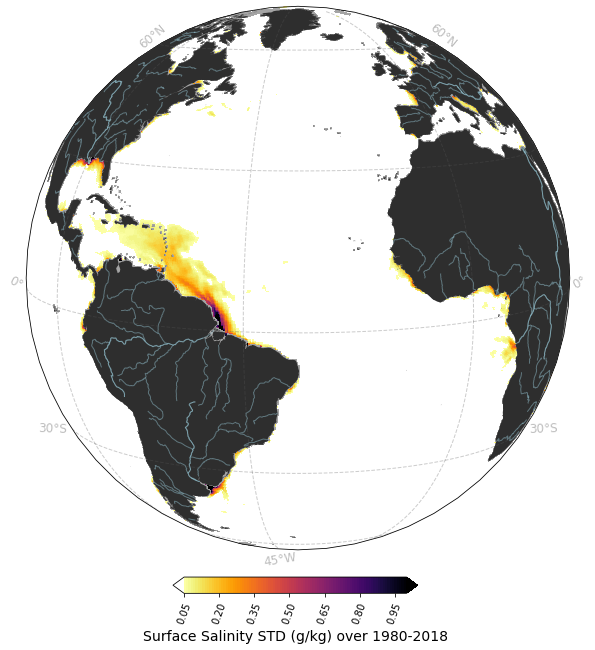

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


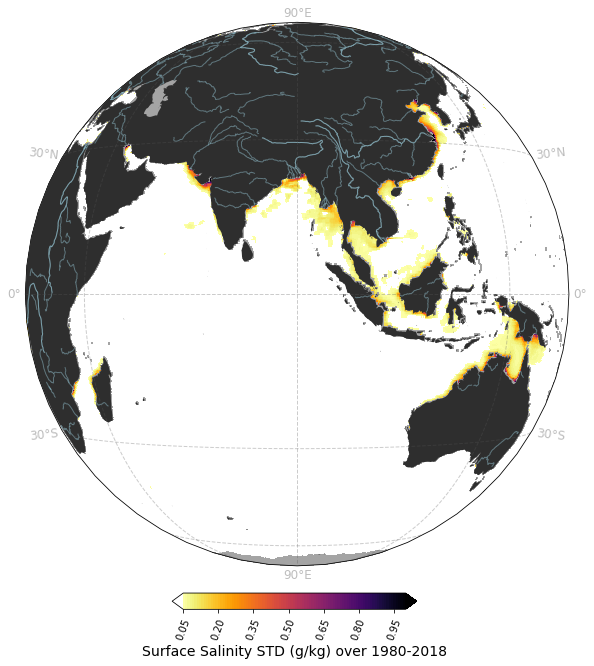

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


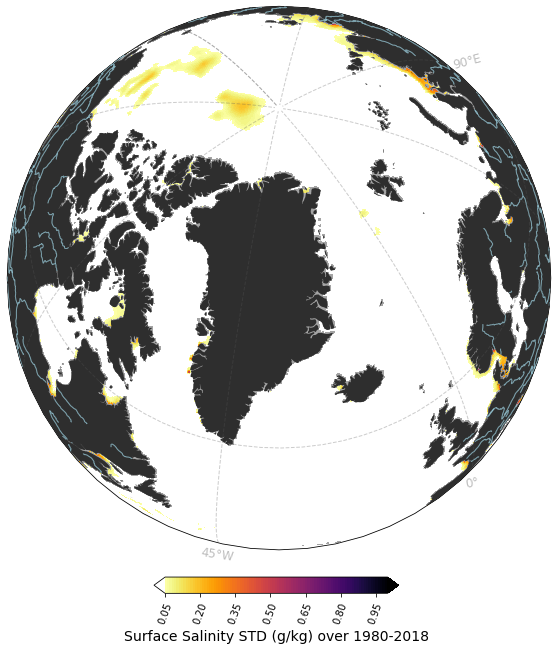

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


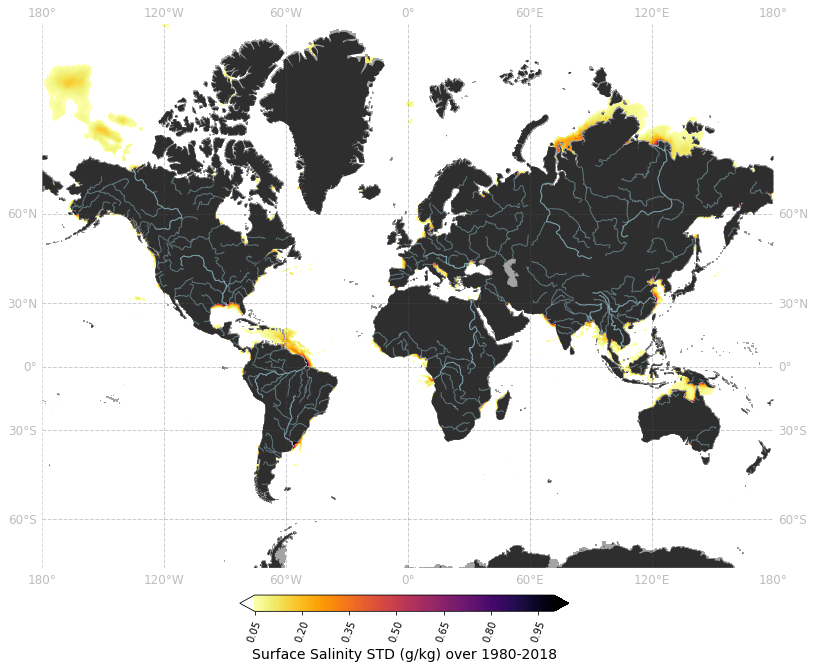

In [15]:
# REGION TO PLOT
#reg='atl'
for reg in ('atl','ind','gro','GLO'): # region loop
    
    # RUN to PLOT
    iexp='DIFF'   #nexp #'DIFF'  # nexp, nexpREF, 'DIFF', 'FCY'

    # PLOT NAME
    namo = "JZmapSPH"+reg+"_SSSdt_STD_"+fo+"_"+iexp+"_"+y1+"-"+y2
    
    if iexp=='DIFF':
        namo = "JZmapSPH"+reg+"_SSSdt_STD_"+fo+"_"+iexp+"_"+nexp+"-"+nexpREF+"_"+y1+"-"+y2

    #========= DATA TO PLOT

    # main variable
    if iexp==nexp:
        data2plot  = STDsss1y_dt.where(tmask!=0,0).squeeze()
    if iexp==nexpREF:
        data2plot  = STDsss1y_ref_dt.where(tmask!=0,0).squeeze()
    if iexp=='DIFF':
        data2plot  = STDsss1y_dt - STDsss1y_ref_dt
        data2plot  = data2plot.where(tmask!=0,0).squeeze()   


    # lat lon
    lon2plot   = nav_lon.squeeze()
    lat2plot   = nav_lat.squeeze()
    # land mask from model
    m2plt      = tmask.where(tmask==0)
    # distance to the coast
    #pltdist   = distcoast


    #========= Plot settings ===============
    if iexp=='DIFF':
        #levbounds=[0.1,1.51,0.01]
        levbounds=[0.05,1.01,0.01]
    else:
        levbounds=[0.1,1.01,0.01]

    # COLORMAP
    co='in' # inferno
    #add indication of colormap to the plot name:
    namo = co+namo

    # rgb color for model land grid points
    r=164
    g=164
    b=164

    # color for continents from data based (hi-res)
    onecohrml='#2E2E2E'


    # customed colormapls
    if (co=='in'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

    if (co=='vi'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='viridis_r',cu='w',co='r')


    # default gridlines parameters
    gridl=False
    incrgridlon=45
    incrgridlat=30

    if reg=='gro':
        loncentr=-35
        latcentr=75
        sath=2085831
    if reg=='atl':
        loncentr=-35
        latcentr=10
        sath=35785831
    if reg=='ind':
        loncentr=90
        latcentr=0
        sath=35785831

    if reg=='GLO':
        minlat=-70.0
        maxlat=84.0
        minlon= -180
        maxlon=179
        loncentr=0
        incrgridlon=60
        incrgridlat=30 


    #================================================================
    #========= CREATE FIGURE
    fig3 = plt.figure(figsize=([18,10]),facecolor='white')

    #========= PLOT DATA
    # Data system proj (if coords are in lat lon, use PlateCarre here)
    trdata  = ccrs.PlateCarree() 

    if (reg=='GLO'):
        ax = plt.axes(projection= ccrs.Mercator(central_longitude=loncentr,min_latitude=minlat, max_latitude=maxlat, globe=None))
    else:
        ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath))

    cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

    # plot grey shading  where ocean mask is 0 (land gridpoints in the model)
    cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',cmap=slx.make_SLXcolormap(reverse=False,whichco='oneco',r=r,g=g,b=b),transform=trdata)

    # plot line at distance 150 km from the coast
    #cs3 = plt.contour(lon2plot, lat2plot,pltdist,levels=[150000],colors=[onecohrml],linestyles=[":"],transform=trdata,zorder=30)


    #========= Text annotation on the map
    # transform = trdata._as_mpl_transform(ax)
    #plt.annotate(pltyr,xy=(60,40),xycoords=transform, color='#BDBDBD',size=25,zorder=10)


    #========= coastlines and gridlines

    # cartopy basic options for coastlines
    #cl = ax.coastlines(color= '#BDBDBD')
    #
    # cartopy FEATURES
    rivers = cartopy.feature.NaturalEarthFeature(
        category='physical', name='rivers_lake_centerlines',
        scale='50m',facecolor='none',edgecolor='b')

    #lands = cartopy.feature.NaturalEarthFeature(
    #    category='physical', name='coastline',
    #    scale='50m',facecolor='none',edgecolor='k')

    cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor=onecohrml,edgecolor= 'none',alpha=1,zorder=5)
    clr = ax.add_feature(cartopy.feature.RIVERS,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)
    clr2 = ax.add_feature(rivers,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)  ##CEE3F6

    #========= GRIDLINES
    gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
    label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
    gl.xlabel_style = label_style
    #gl.xlabels_bottom = False
    gl.ylabel_style = label_style
    #gl.ylabels_right = False

    if (reg=='GLO'):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.axis('off')

    #========= ADD COLORBAR
    cbon=True
    if cbon:
            tlabel="Surface Salinity STD (g/kg) over "+y1+"-"+y2
            cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=15,tformat="%.2f",
                                 tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                                bbta=(-0.18,-0.25,0.9,0.2))  

    #========= PLT SHOW AND SAVE
    plt.show()

    # Save fig in png, resolution dpi    
    slx.saveplt(fig3,diro,namo,dpifig=300)
    plt.close(fig3)